In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.model_selection import train_test_split
import seaborn as sns; sns.set()
from emcee import EnsembleSampler
from emcee.moves import DEMove, DESnookerMove
import corner

/home/carlisle/anaconda3/envs/myenv/lib/python3.11/site-packages/numba/np/ufunc/dufunc.py:84: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  dispatcher = jit(_target='npyufunc',


In [2]:
def train_PCA_GPE(training_data, theta, primary_components = 2): 
    ss = StandardScaler()
    training_data_scaled = ss.fit_transform(training_data)    
    pca = PCA(n_components = primary_components, whiten = True)
    training_data_PCAd = pca.fit_transform(training_data_scaled)
    gpes = []
    
    for z in training_data_PCAd.T[:primary_components]: # optimize hyper parameters for each pc
        kernel = 1 * RBF(length_scale = 1 * np.ones(theta.shape[1]), 
                         length_scale_bounds = (1e-10, 1e10)) + 1 * WhiteKernel()
        gpe = GaussianProcessRegressor(kernel = kernel,  n_restarts_optimizer = 5) #, normalize_y = True)
        gpes.append(gpe.fit(theta, z))
    
    return gpes, pca, ss

def invert_cov(cov, var_trans, nsamples, nkp):
    return np.dot(np.array(cov).T, var_trans).reshape(nsamples, nkp, nkp) # A.T * cov * A ?

def return_predictions(emulators, theta, return_std_ = True): # fix for return_std = False
    gpes = emulators[0]
    pca = emulators[1]
    ss = emulators[2]
    nsamples = len(theta)
    npc = len(gpes) # number of principal components
    nkp = np.shape(ss.scale_)[0] # number of kinematical points
                   
    mean_prediction = []
    cov_prediction = []
    
    for gpe in gpes: # predicts per principal component: len(gpes) = npc 
        
        mean, cov = gpe.predict(theta, return_cov = return_std_)
        gp_var2 = cov.diagonal()[:, np.newaxis]
        
        mean_prediction.append(mean)
        cov_prediction.append(gp_var2)

    # inverse transform mean prediction
    pred_r = ss.inverse_transform(pca.inverse_transform(np.array(mean_prediction).T))
    
    # make transformation matrix for error
    trans_matrix = pca.components_ * np.sqrt(pca.explained_variance_[:, np.newaxis]) # transformation matrix
    A = trans_matrix[:npc] 
    var_trans = np.einsum('ki,kj->kij', A, A, optimize = False).reshape(npc, nkp**2)
    
    # inverse transform diagonal covariance matrix
    cov_rpca = invert_cov(cov_prediction, var_trans, nsamples, nkp)
    std_preds = np.sqrt(np.diagonal(cov_rpca, axis1 = 1, axis2 = 2)) # standard devs are just
    err_r = ss.scale_ * std_preds
    
    return pred_r, err_r

# log formulas

# log likelihood
def log_likelihood(theta, emulators, data, data_err): # one set of theta only
    theta_reshaped = theta.reshape(1,-1)
    predict, predict_err = return_predictions(emulators, theta_reshaped, return_std_ = True)    
    err2 = (predict_err**2 + (data_err)**2) 
    ll = np.log(2*np.pi*err2) + ((data - predict)**2) / err2 #np.log is natural log 
    return -.5*np.sum(ll)

# some flat prior that sets the bounds of the parameters
def log_flat_prior(theta, l_bounds, u_bounds):
    
    for i in range(np.size(theta)): # check if each parameter is within bounds
        if theta[i] < l_bounds[i] or theta[i] > u_bounds[i]:
            return -np.inf
       
    return 0

# posterior
def log_posterior(theta, l_bounds, u_bounds, emulators, data, data_err):
    return log_likelihood(theta, emulators, data, data_err) + log_flat_prior(theta, l_bounds, u_bounds)

# emcee sampler function
def emcee_sampler(n_walkers, n_params, log_posterior, l_bounds, u_bounds, emulators, data, data_err, moves = None):
    sampler = EnsembleSampler(n_walkers, 
                              n_params, 
                              log_posterior,
                              moves = moves,
                              #moves = [(DEMove(), 0.8), (DESnookerMove(), 0.2)], 
                              args = [l_bounds, u_bounds, emulators, data, data_err], 
                              threads = 4) # default is stretchmove
    return sampler

def return_samples(p0, l_bounds, u_bounds, n_walkers, n_params, n_samples, n_burn, sampler):
    burn = sampler.run_mcmc(p0, n_burn, progress = True) # initially train until samples converge
    sampler.reset() # remove burn samples
    run = sampler.run_mcmc(burn, n_samples, progress = True)
    return sampler.get_chain(flat = True)

In [3]:
def plot_model_vs_exp(q2s, ss, model_values, exp_df):
    colors  = ['orange', 'purple', 'yellow', 'pink', 'red','cyan', 'maroon', 'teal', 'green']
    for j in range(len(q2s)):
        q2 = q2s[j]
        Q2_region = (exp_df['Qs2'] == q2) & (exp_df['sqrt(s)'] == ss)
        Q2_indeces = exp_df.index[Q2_region].tolist()
        exp_df_region = exp_df[Q2_region]
        dat = np.array(exp_df_region['sigma_r'])
        dat_err = np.array(exp_df_region['error'])
        xb = np.array(exp_df_region['xbj'])
 
        for i in range(len(model_values)):
            model = [ model_values[i,qq2] for qq2 in Q2_indeces]
            if i == 0:
                plt.plot(xb, model, alpha = 0.8, linewidth = 1.0, color = colors[j], label = "${}$".format((q2)))
            else:
                plt.plot(xb, model, alpha = 0.5, linewidth = 0.3, color = colors[j])
                
        if j == 0:
            plt.errorbar(xb, dat, yerr = dat_err, color = 'black', fmt = '.', label = "Data")        
        else:
            plt.errorbar(xb, dat, yerr = dat_err, color = 'black', fmt = '.')


    plt.xlabel("$x_{bj}$", fontsize = 18)
    plt.ylabel("$\sigma_r$ (mb)", fontsize = 18)
    # set y and x label font sizes
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    plt.xscale('log')
    plt.xlim = (10e-6, 10e-1) 
    plt.ylim = (0.4, 1.6)
    plt.title("5-parameter fit", fontsize = 20)
    #plt.yscale('log')
    # place legend outside of plot
    plt.legend(title = "$Q^2$ (GeV$^2$)", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    #plt.legend(title = "$Q^2$ (GeV$^2$)")
    return plt.show()


In [4]:
def plot_exp_vs_map_vs_median(q2s, ss, map_values, exp_df, median_values):
    
    colors  = ['orange', 'purple', 'brown', 'pink', 'maroon', 'olive', 'cyan', 'magenta', 'teal', 'green']
    for j in range(len(q2s)):
        q2 = q2s[j]
        Q2_region = (exp_df['Qs2'] == q2) & (exp_df['sqrt(s)'] == ss)
        Q2_indeces = exp_df.index[Q2_region].tolist()
        exp_df_region = exp_df[Q2_region]
        dat = np.array(exp_df_region['sigma_r'])
        dat_err = np.array(exp_df_region['error'])
        xb = np.array(exp_df_region['xbj'])

        for i in range(len(map_values)):
            model = [map_values[i,qq2] for qq2 in Q2_indeces]
            plt.plot(xb, model, '--', alpha = 0.9, color = colors[j], label = "MAP estimates")

        for i in range(len(median_values)):
            model = [median_values[i,qq2] for qq2 in Q2_indeces]
            plt.plot(xb, model, alpha = 0.5, color = colors[j], label = " Posterior median")

    # for i in range(len(median_values_low)):
    #     modellow = [median_values_low[i,qq2] for qq2 in Q2_indeces]
    #     modelhigh = [median_values_high[i,qq2] for qq2 in Q2_indeces]
    #     plt.fill_between(xb, modellow, modelhigh, alpha = 0.4, label = "{} credible region".format(confidence))
    
        plt.errorbar(xb, dat, yerr = dat_err, color = 'black', fmt = '.', label = "HERA Data")
    
    #plt.title(r"$Q^2 = {} $".format((q2)) + r" GeV$^2$; $\sqrt{s}$" + " = {} GeV".format(ss))   
    plt.xlabel("$x_{bj}$")
    plt.ylabel("$\sigma_r$ (mb)")
    plt.xscale('log') 
    #plt.legend()
    return plt.show()


In [5]:
def plot_model_vs_exp_wtrain(q2, ss, model_values, exp_df):
    splots = 2
    fig, ax = plt.subplots(1,splots, figsize = (16, 6))

    Q2_region = (exp_df['Qs2'] == q2) & (exp_df['sqrt(s)'] == ss)
    Q2_indeces = exp_df.index[Q2_region].tolist()
    exp_df_region = exp_df[Q2_region]
    dat = np.array(exp_df_region['sigma_r'])
    dat_err = np.array(exp_df_region['error'])
    xb = np.array(exp_df_region['xbj'])
    

    for i in range(len(model_values)):
        model = [model_values[i,qq2] for qq2 in Q2_indeces]
        ax[0].plot(xb, model, alpha = 0.3, color = 'orange',linewidth = 0.5)
        if i == len(model_values)-1:
            ax[0].plot(xb, model, alpha = 0.9, color = 'orange', linewidth = 0.5, label = "Emulator (Posterior Samples)") 
    
    ax[0].plot(np.average(model))
        
    for i in range(len(training_set_all)):
        train = [training_set_all[i,qq2] for qq2 in Q2_indeces]
        ax[1].plot(xb, train, alpha = 0.3, color = 'orange', linewidth = 0.5)
        if i == len(pred_r)-1:
            ax[1].plot(xb, train, alpha = 0.9, color = 'orange', linewidth = 0.5, label = "Training Data")

    for i in range(splots):
        ax[i].errorbar(xb, dat, yerr = dat_err, color = '#0343DF',  fmt = '.', alpha = 0.7, label = "HERA Data")
        ax[i].set_title("$Q^2$ = {} GeV$^{}$; ".format(q2, 2) + "$\sqrt{s}$ = " + str(ss) + " GeV")
        ax[i].set_xlabel("$x_{bj}$")
        ax[i].set_ylabel("$\sigma_r$ (mb)")
        #ax[0].set_ylim(0.5, 2.0)
        ax[i].set_xscale('log') 
        #ax[i].set_yscale('log')
        ax[i].legend()
        
    return plt.show()
 # make cuts
 # check chi2

In [6]:
#fig_label = "4p100d232k"

#folder = "mv5/orthLHS/121d" #"mve/hybrid" #"mve/orthLHS/121d" # w3p20d
folder = "mv5/plainLHS/500d"
train_file, theta_file = [folder + "/train.dat", folder + "/theta.dat"]

folder2 = "mv5/plainLHS/100d"
train_file2, theta_file2 = [folder2 + "/train.dat", folder2 + "/theta.dat"]


exp_file = "exp_all.dat"
param_names = ["$Q_{s0}^{2}$ (GeV²)",
               "$\gamma$",
               "$e_c$",
               "$C^{2}$",
               "$\sigma_0/2$ (mb)"] # ordered
n_params = len(param_names)

# cut training data ()
exp_df = pd.DataFrame(np.loadtxt(exp_file), columns = ['xbj', 'Qs2', 'sqrt(s)', 'sigma_r', 'error'])
a, b = 2.0, 50.0 
# Q2_region = exp_df['Qs2'] < 10.0 # boolean
Q2_region = (exp_df['Qs2'] >= a) & (exp_df['Qs2'] <= b)
Q2_index = exp_df.index[Q2_region].tolist()
exp_df = exp_df[Q2_region]
xbj = np.array(exp_df['xbj'])
exp = np.array(exp_df['sigma_r'])
exp_err = np.array(exp_df['error'])

In [7]:
train_dataset1 = pd.DataFrame(np.loadtxt(train_file))
train_dataset2 = pd.DataFrame(np.loadtxt(train_file2))
train_dataset = pd.concat([train_dataset1, train_dataset2], ignore_index=True)
train_dataset = train_dataset.iloc[:, Q2_index].T.reset_index(drop=True).T
train_dataset = pd.DataFrame(np.loadtxt(train_file))
training_set_all = train_dataset.iloc[:,np.array(train_dataset.columns)].values
params_1 = np.vstack(np.loadtxt(theta_file, unpack = True)).T
params_2 = np.vstack(np.loadtxt(theta_file2, unpack = True)).T
params_all = np.vstack([params_1, params_2])
params_all = np.vstack(np.loadtxt(theta_file, unpack = True)).T

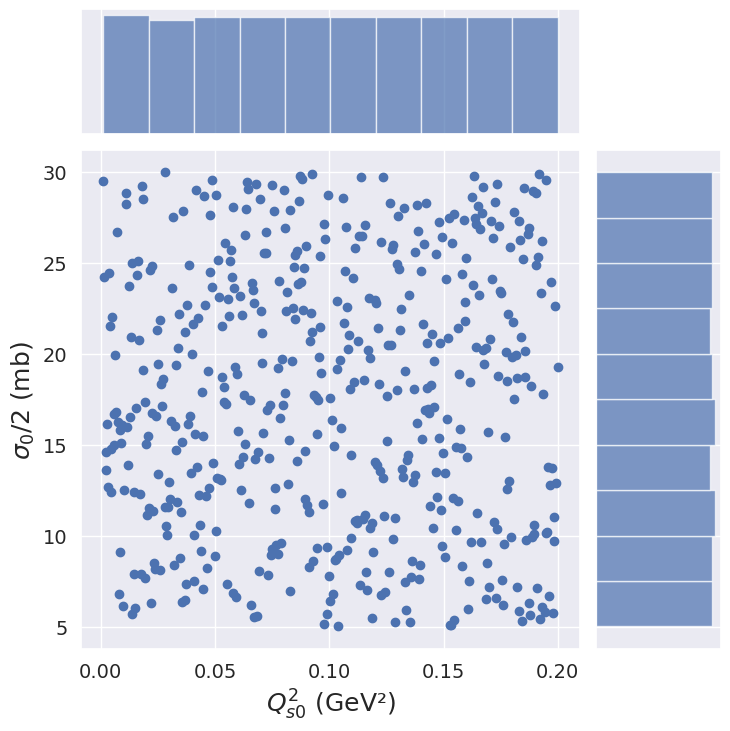

In [8]:
def scatter_hist(a, b, ax, ax_histx, ax_histy):
    # no labels
    x = params_all[:,a]
    y = params_all[:,b]
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)
    ax.set_xlabel(param_names[a], fontsize = 18)
    ax.set_ylabel(param_names[b], fontsize = 18)
    # set fontsize of tick labels
    ax.tick_params(axis='both', which='major', labelsize=14)
    #ax.tick_params(axis='both', which='minor', labelsize=8)
    ax_histx.hist(x, bins=10, alpha=0.7)
    ax_histy.hist(y, bins=10, orientation='horizontal', alpha=0.7)
    #remove y tick labels from histx and histy
    ax_histx.set_yticks([])
    ax_histy.set_xticks([])

# Start with a square Figure.
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(0, 4, ax, ax_histx, ax_histy)
#plt.ylabel(r"$\gamma$")

In [9]:
# space for validating() the gpe emulator
# z = np.zeros(20)
# ems = []
# prims = []
# for i in range(20):
#     prim = i + 2
#     prims.append(prim)
#     emulators0 = train_PCA_GPE(training_set_all, params_all, primary_components = prim)
#     ems.append(emulators0)
#     pred_rs, err_rs = return_predictions(ems[i], params_all, return_std_ = True)
#     z_mean = []
#     for f in range(np.shape(pred_rs)[1]):
#         zs = np.mean(np.abs(pred_rs[:,f] - training_set_all[:,f]) / err_rs[:,f])
#         z_mean.append(zs)
#     z[i] = np.mean(z_mean)
#     #z[i] = emulators0[3]
#         #z[i] = np.mean(np.abs(err_rs))

# npc = np.where( z == np.amin(z, axis = 0))[0][0] + 2
# fig = plt.plot(prims, z, '.')
# plt.xlabel("Number of Principal Components")
# plt.ylabel("Mean Relative Difference")

In [10]:
# train pca, scaler, and gpe
npc = 5
#emulators = train_PCA_GPE(training_set, myparams, primary_components = npc)
emulators = train_PCA_GPE(training_set_all, params_all, primary_components = npc)
# return predictions of fits
pred_r, err_r = return_predictions(emulators, params_all, return_std_ = True)
#pred_r_train, err_r_train = return_predictions(emulators, myparams, return_std_ = True)

1.207 0.013337213460839561
0.0005


Text(0, 0.5, '$\\sigma_r$')

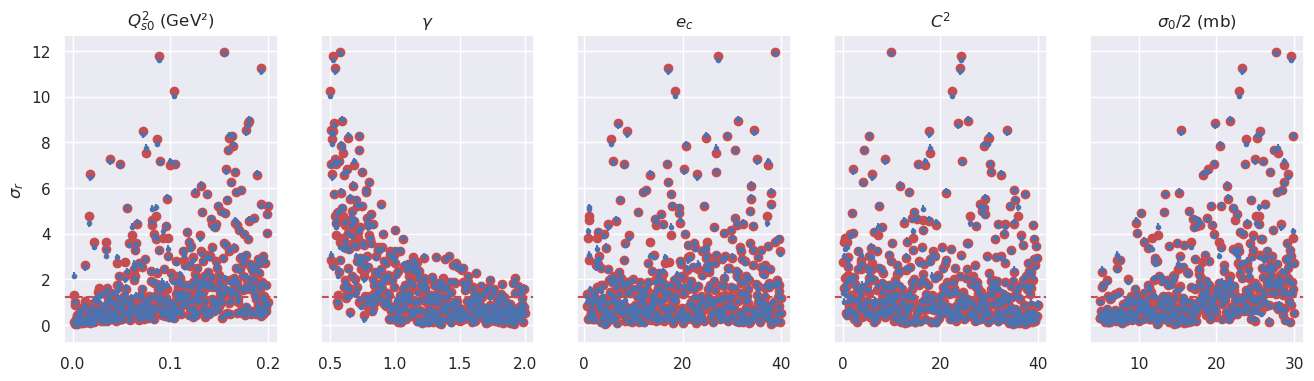

In [11]:
# plot for first kinematical point, comparing training da$Q_{s0}^{2}$ (GeV²)= 0.166
kp = 100
f, ax = plt.subplots(1, n_params, sharey = True, figsize=(16,4))
for i in range(0,n_params):
    #ax[i].errorbar(myparams_test[:,i], pred_r[:,kp], fmt = '.', yerr = err_r[:,kp], label = "GPE Prediction on Test")
    ax[i].errorbar(params_all[:,i], pred_r[:,kp], fmt = '.', yerr = err_r[:,kp], label = "GPE Prediction on Train")
    ax[i].plot(params_all[:,i], training_set_all[:,kp], 'ro', label = 'Test')
    ax[i].axhline(exp[kp],  color = 'r', linestyle = '--', label = 'HERA value')
    ax[i].set_title(param_names[i])
    #ax[i].legend()
    #ax[i].set_ylim(-2, 8)

# ax[1].set_xscale("log")    
print(exp[kp], exp_err[kp])
print(xbj[kp])
ax[0].set_ylabel(r"$\sigma_r$")

Text(0.5, 0, 'Training Data $\\sigma_r$')

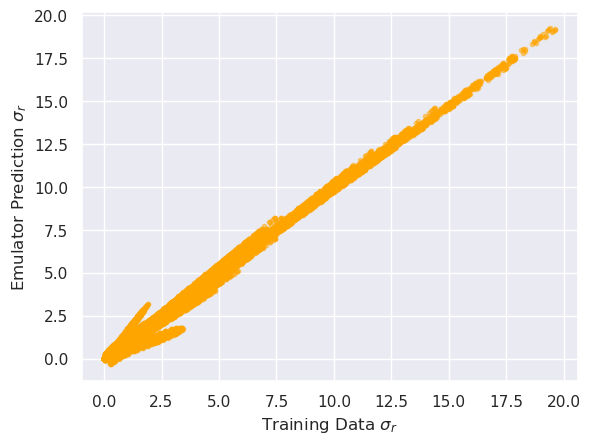

In [12]:
diag = np.linspace(0,9)
plt.plot(diag, diag, '--', color = 'black', alpha = 0.5)

for i in range(403):
    plt.plot(training_set_all[:,i], pred_r[:,i], '.', color = "orange", alpha = 0.5)

plt.ylabel("Emulator Prediction $\sigma_r$")
plt.xlabel("Training Data $\sigma_r$")
#plt.ylim(0.0, 1.0)
#plt.xlim(0.0, 1.0)

(-2.5, 2.5)

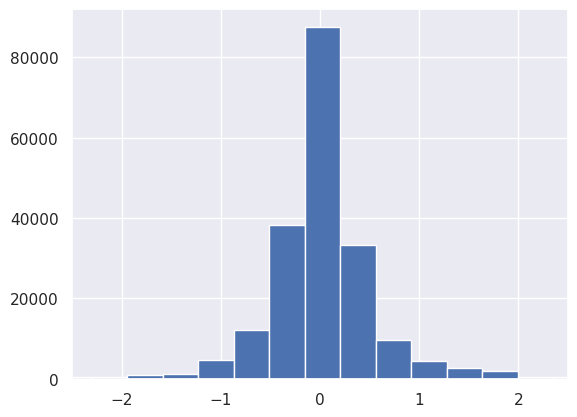

In [13]:
z = np.array([(pred_r[:,kp] - training_set_all[:,kp]) / err_r[:,kp] for kp in range(403)])
plt.hist(z.flatten(), bins = 50)
# set x limit of histogram
plt.xlim(-2.5, 2.5)


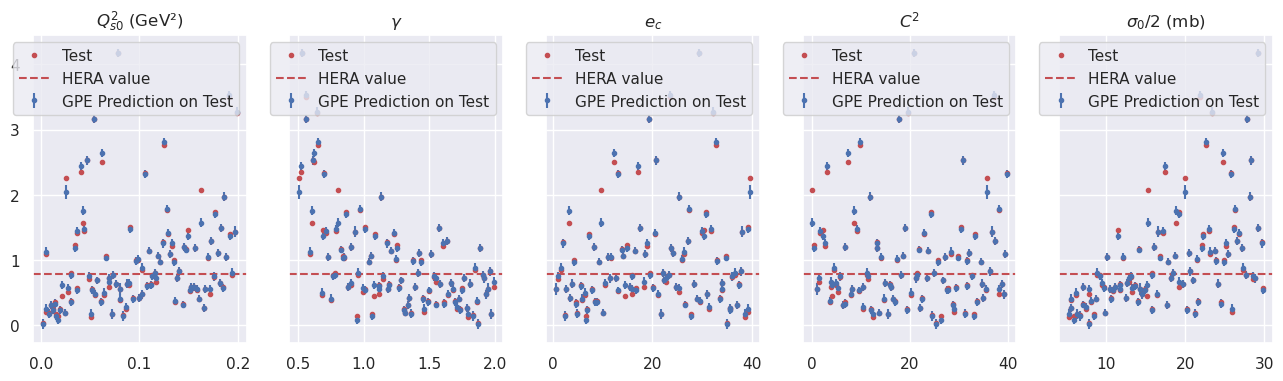

In [14]:
folder_val = "mv5/plainLHS/100d" #"mve/hybrid" #"mve/orthLHS/121d" # w3p20d
train_file_val, theta_file_val = [folder_val + "/train.dat", folder_val + "/theta.dat"]
train_dataset_val = pd.DataFrame(np.loadtxt(train_file_val))
train_dataset_val = train_dataset_val.iloc[:, Q2_index].T.reset_index(drop=True).T
training_set_val = train_dataset_val.iloc[:,np.array(train_dataset_val.columns)].values
myparams_val = np.vstack(np.loadtxt(theta_file_val, unpack = True)).T
pred_val, err_val = return_predictions(emulators, myparams_val, return_std_ = True)
kp = 0
f, ax = plt.subplots(1, n_params, sharey = True, figsize=(16,4))
for i in range(0,n_params):
    ax[i].errorbar(myparams_val[:,i], pred_val[:,kp], fmt = '.', yerr = err_val[:,kp], label = "GPE Prediction on Test")
    #ax[i].errorbar(myparams[:,i], pred_r_train[:,kp], fmt = '.', yerr = err_r_train[:,kp], label = "GPE Prediction on Train")
    ax[i].plot(myparams_val[:,i], training_set_val[:,kp], 'r.', label = 'Test')
    ax[i].axhline(exp[kp],  color = 'r', linestyle = '--', label = 'HERA value')
    ax[i].set_title(param_names[i])
    ax[i].legend()

Text(0.5, 0, 'z-score')

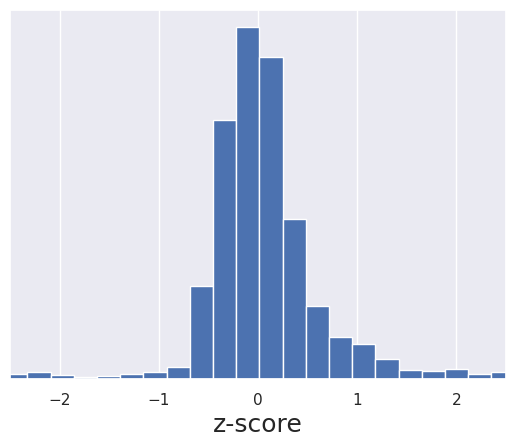

In [15]:
z_val = np.array([(pred_val[:,kp] - training_set_val[:,kp]) / err_val[:,kp] for kp in range(403)])
plt.hist(z_val.flatten(), bins = 50);
plt.xlim(-2.5,2.5)
# remove x ticks label
plt.yticks([], fontsize = 14)
plt.xlabel("z-score", fontsize = 18)

Text(0.5, 0, 'Model Calculation')

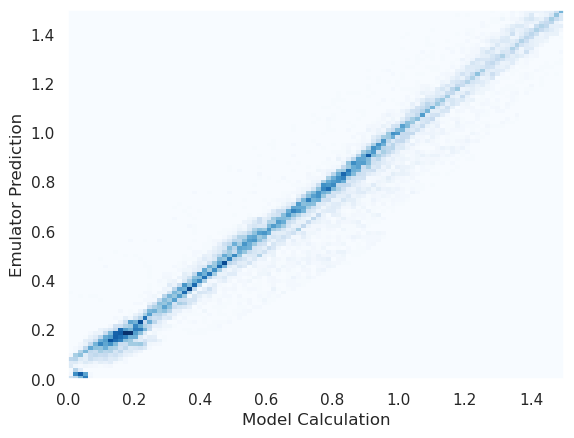

In [16]:
diag = np.linspace(0,2)
#plt.plot(diag, diag, '--', color = 'black', alpha = 0.5)

pred_all = []
training_set_flat_all = []
for i in range(403):
    pred_flat = pred_val[:,i]
    pred_all.append(pred_flat)
    training_set_flat = training_set_val[:,i]
    training_set_flat_all.append(training_set_flat)
    #plt.plot(training_set_flat, pred_flat, '.', color = "orange", alpha = 0.5)
    #plt.hist2d(pred_val[:,i], training_set_val[:,i], '.', color = "orange", alpha = 0.5)

plt.hist2d(np.array(pred_all).flatten(), 
           np.array(training_set_flat_all).flatten(), 
           bins = 100,
           range = [[0, 1.5], [0, 1.5]],
           cmap = "Blues")
plt.ylabel("Emulator Prediction")
plt.xlabel("Model Calculation")
#plt.ylim(0.0, 2.0)
#plt.xlim(0.0, 2.0)

Text(0, 0.5, 'Training Data $\\sigma_r$')

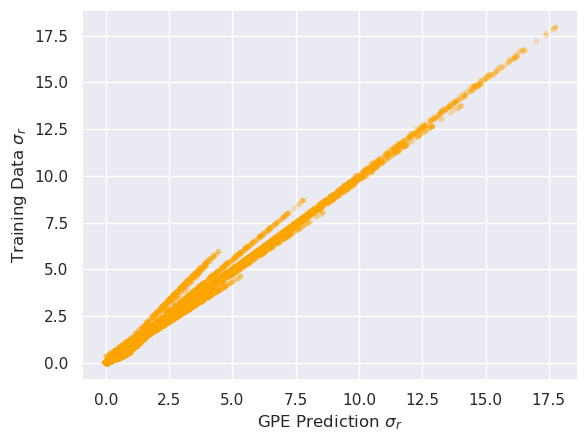

In [17]:
diag = np.linspace(0, 5)
plt.plot(diag, diag, '--', color = 'black', alpha = 0.5)

for i in range(400):
    #plt.plot(pred_r[:,i], training_set_test[:,i], '.', color = "orange", alpha = 0.5)
    plt.plot(pred_val[:,i], training_set_val[:,i], '.', color = "orange", alpha = 0.2)

plt.xlabel("GPE Prediction $\sigma_r$")
plt.ylabel("Training Data $\sigma_r$")
#plt.ylim(0.0, 0.5)
#plt.xlim(0.0, 0.5)

In [120]:
# are there still negative values in the err_r
for i in range(len(exp)):
    for num in err_r[:,i]:
        if num < 0:
            print(num, end=" ")

In [121]:
# getting MAP values

from scipy.optimize import minimize, basinhopping
#posterior_median = np.median(paramsamples, axis = 0) # median values of the posterior as initial guess; code still works for other guesses, it just takes longer to run 
l_bounds = [0.001, 0.5, 0.5, 0.1, 5.0] # Qs0² , gamma, ec , C², sigma0/2
u_bounds = [0.2, 2.0, 40.0, 40.0, 30.0] 
initial_guess = np.array([0.06, 1.0, 18.9, 7.2, 16.36]) # mve from paper

#MAP1 = minimize(lambda theta: -log_posterior(theta, l_bounds, u_bounds, emulators, exp, exp_err), initial_guess)
MAP1 = minimize(lambda theta: -log_likelihood(theta, emulators, exp, exp_err), initial_guess)
print("Initial Guess for minimize: ", initial_guess)
print("log likelihood at initial guess:", -log_likelihood(initial_guess, emulators, exp, exp_err))
print("minimize estimates: ", MAP1.x)
print("log likelihod at minimize", MAP1.fun)

map2_kwargs = {"method": "BFGS"}
#MAP2 = basinhopping(lambda theta: -log_posterior(theta, l_bounds, u_bounds, emulators, exp, exp_err), initial_guess, niter = 200, minimizer_kwargs = map2_kwargs)
MAP2 = basinhopping(lambda theta: -log_likelihood(theta, emulators, exp, exp_err), initial_guess)
print("basinhopping estimates: ", MAP2.x)
print("log likelihood at basinhopping", MAP2.fun)


Initial Guess for minimize:  [ 0.06  1.   18.9   7.2  16.36]
log likelihood at initial guess: -22.012109103069225
minimize estimates:  [ 0.06652198  1.09296766 25.36141089  9.62366515 16.32426594]
log likelihod at minimize -460.997423805215
basinhopping estimates:  [ 0.07243663  1.14611655 15.43446152 11.0621818  17.32301805]
log likelihood at basinhopping -462.40689609669033


In [122]:
# initializes the walkers in either a small space around the initial guess
# or in a larger space. Well we'll see how it goes
# initialize
l_bounds = [0.001, 0.50, 0.5, 0.1, 5.0] # Qs0² , gamma, ec , C², sigma0/2
u_bounds = [0.2, 2.0, 40.0, 40.0, 30.0]

# [ 0.16487977  1.17362474 31.9729632   0.10056809  7.8739019 ]
# [ 0.16429921  1.17286339 32.91302409  0.63792114  7.90410021]
# initialized at final MAP
#l_bounds_in = [0.15, 1.1, 30.0, 0.5, 6.0]
#u_bounds_in = [0.17, 1.2, 34.0, 0.8, 9.0]

mylimits = np.array([l_bounds, u_bounds])
n_walkers = 100
n_burn = 1500 # 2000
n_samples = 1000

p0 = np.random.uniform(l_bounds, u_bounds, size = (n_walkers,n_params))
sampler1 = emcee_sampler(n_walkers, n_params, log_posterior, l_bounds, u_bounds, emulators, exp, exp_err)
paramsamples = return_samples(p0,l_bounds, u_bounds, n_walkers, n_params, n_samples, n_burn, sampler1)

for i in range(n_params): # print means
    print(param_names[i] + "= {0:.3f}".format(np.mean(paramsamples[:,i])))

print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler1.acceptance_fraction)))

100%|██████████| 1000/1000 [37:35<00:00,  2.26s/it]

$Q_{s0}^{2}$ (GeV²)= 0.068
$\gamma$= 1.127
$e_c$= 17.138
$C^{2}$= 11.581
$\sigma_0/2$ (mb)= 17.440
Mean acceptance fraction: 0.314


In [123]:
# here we find the map values after the sampling with the median values as initial guess
posterior_median = np.median(paramsamples, axis = 0) # median values of the posterior as initial guess; code still works for other guesses, it just takes longer to run
MAP = minimize(lambda theta: -log_posterior(theta, l_bounds, u_bounds, emulators, exp, exp_err), posterior_median)
percentile_16 = np.percentile(paramsamples, 16, axis = 0)
percentile_84 = np.percentile(paramsamples, 84, axis = 0)
percentile_5 = np.percentile(paramsamples, 5, axis = 0)
percentile_95 = np.percentile(paramsamples, 95, axis = 0)

print("MAP estimates: ", MAP.x)
print("log posterior at MAP: ", MAP.fun)
print("Median Values: ", posterior_median)
print("log posterior at Median: ", -log_posterior(posterior_median, l_bounds, u_bounds, emulators, exp, exp_err))
print("16th percentile: ", percentile_16)
print("84th percentile: ", percentile_84)
print("5th percentile: ", percentile_5)
print("95th percentile: ", percentile_95)

/home/carlisle/anaconda3/envs/myenv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/carlisle/anaconda3/envs/myenv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/carlisle/anaconda3/envs/myenv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/carlisle/anaconda3/envs/myenv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/carlisle/anaconda3/envs/myenv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


MAP estimates:  [ 0.06783556  1.12884874 16.22891098 10.90140365 17.37447475]
log posterior at MAP:  -462.0871639637148
Median Values:  [ 0.06783556  1.12884874 16.22891098 10.90140365 17.37447475]
log posterior at Median:  -462.0871639637148
16th percentile:  [ 0.05605331  1.06348722 11.44420611  7.9762215  16.12184496]
84th percentile:  [ 0.08070987  1.1823636  22.6453597  14.0252691  19.02557022]
5th percentile:  [ 0.04758926  1.00355867  9.21862824  6.33881384 15.3691198 ]
95th percentile:  [ 0.09098587  1.21490686 28.50084029 20.63200722 20.19468184]


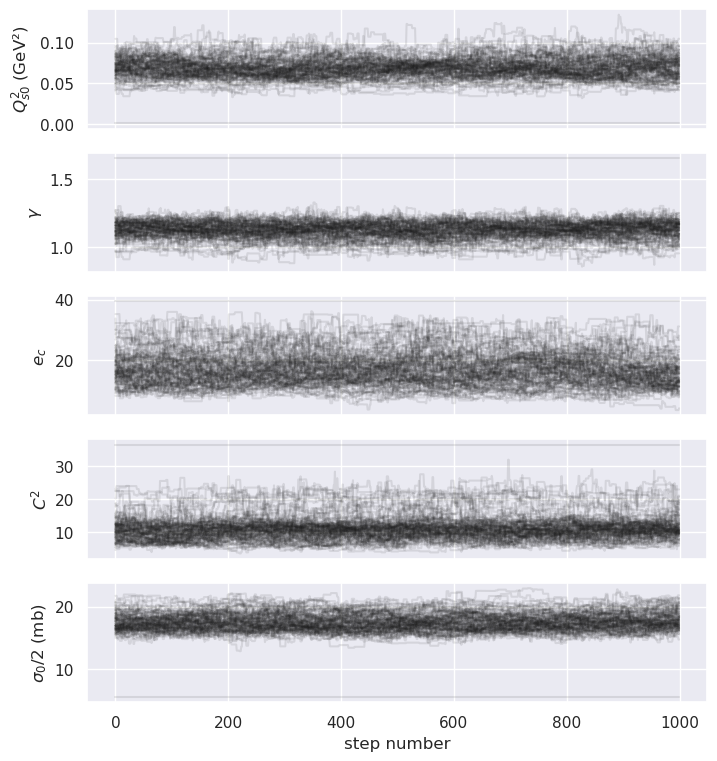

In [124]:
fig, axes = plt.subplots(n_params, 1, sharex = True, figsize = (8, 9))
for i in range(n_params):
    axes[i].plot(sampler1.chain[:,:,i].T, color = 'k', alpha = 0.1)
    axes[i].set_ylabel(param_names[i])
    axes[-1].set_xlabel('step number')

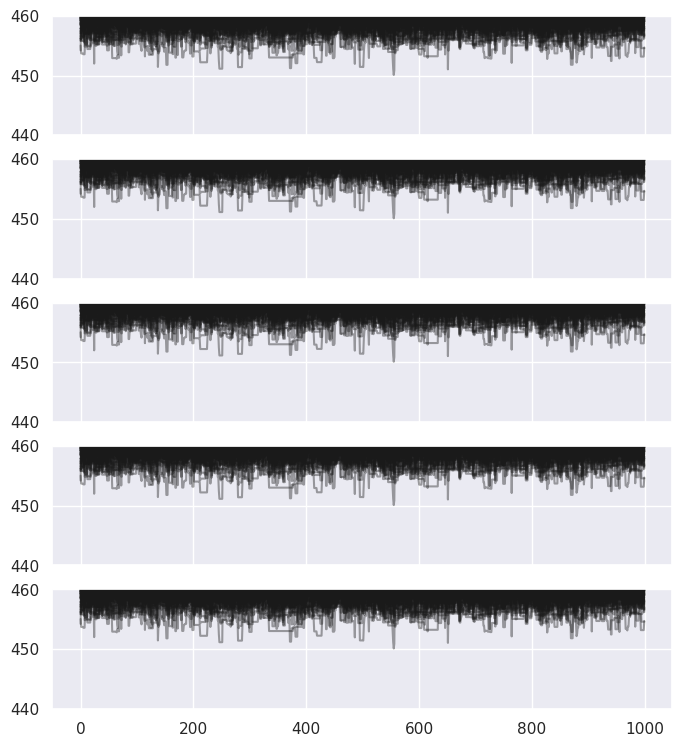

In [125]:
fig, axes = plt.subplots(n_params, 1, sharex = True, figsize = (8, 9))
for i in range(n_params):
    axes[i].plot(sampler1.get_log_prob(), color = 'k', alpha = 0.4)
    axes[i].set_ylim(440, 460)
    #axes[-1].set_xlabel('step number')

In [126]:
# unpack all samples that are saved in txt file
# paramsamples = np.vstack(np.loadtxt("mve/plainLHS/mve_100d_100w_allsamples.txt", unpack = True)).T

Quantiles:
[(0.05, 0.04758925985666171), (0.5, 0.06783555629880293), (0.95, 0.09098586564704828)]
Quantiles:
[(0.05, 1.003558674574744), (0.5, 1.128848735634002), (0.95, 1.2149068647112002)]
Quantiles:
[(0.05, 9.218628244879126), (0.5, 16.228910976511322), (0.95, 28.50084029267304)]
Quantiles:
[(0.05, 6.338813844980448), (0.5, 10.901403646058386), (0.95, 20.6320072211094)]
Quantiles:
[(0.05, 15.369119797572667), (0.5, 17.37447475357314), (0.95, 20.19468183952605)]


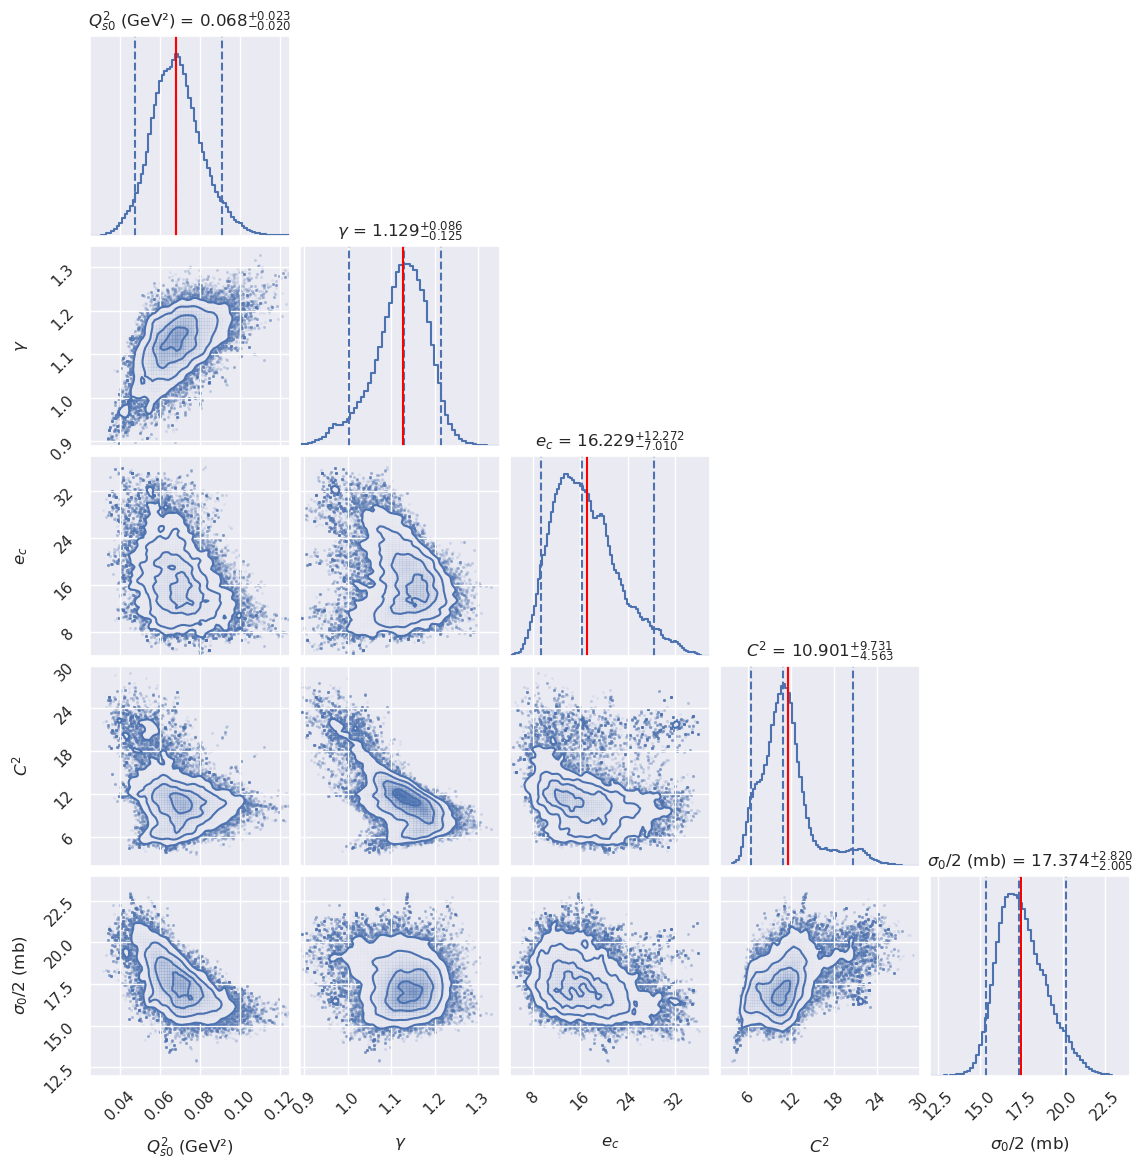

In [140]:
figure = corner.corner(
    paramsamples,
    labels = param_names,
    #plot_contours = True,
    quantiles=[0.05, 0.5, 0.95],
    show_titles = True, # 
    title_fmt = '.3f',
    title_kwargs={"fontsize": 12}, 
    color = 'b',
    bins = 100,
    smooth1d = True,
    smooth = True,
    verbose = True,
    plot_density = True,
    #plot_datapoints = False,
    fillcontours = False, # 
    hist2d_kwargs = {"plot_density": True} # conto
)

ndim = n_params
axes = np.array(figure.axes).reshape((ndim, ndim))
range0 = [0.025, 0.125]
range1 = [0.89,1.35]
range2 = [4.0, 38.0]
range3 = [2.0, 30.0]
range4 = [12.0, 24.0]
ranges = np.array([range0, range1, range2, range3, range4])

for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(np.mean(paramsamples[:,i]), color="red")
    ax.set_xlim(ranges[i])

for yi in range(5):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.set_xlim(ranges[xi])
        ax.set_ylim(ranges[yi])


In [141]:
# # run once
#inds = np.random.randint(len(paramsamples), size=100)
#post_samples = np.array([paramsamples[i] for i in inds])
#np.savetxt("mv5/plainLHS/mv5_600d_100w_sampled_from_posterior_100.txt", np.array(post_samples), delimiter = " ", newline = "\n")
#np.savetxt("mv5/plainLHS/mv5_600d_100w_allsamples.txt", np.array(paramsamples), delimiter = " ", newline = "\n")

In [18]:
post_samples = np.vstack(np.loadtxt("mv5/plainLHS/mv5_500d_100w_sampled_from_posterior_100.txt", unpack = True)).T
paramsamples = np.vstack(np.loadtxt("mv5/plainLHS/mv5_500d_100w_allsamples.txt", unpack = True)).T
model_values, model_values_err = return_predictions(emulators, post_samples, return_std_ = True)

In [19]:
from scipy.optimize import minimize
posterior_median = np.median(paramsamples, axis = 0) # median values of the posterior as initial guess; code still works for other guesses, it just takes longer to run
l_bounds = [0.001, 0.50, 0.5, 0.1, 5.0] # Qs0² , gamma, ec , C², sigma0/2
u_bounds = [0.2, 2.0, 40.0, 40.0, 30.0]
MAP = minimize(lambda theta: -log_posterior(theta, l_bounds, u_bounds, emulators, exp, exp_err), posterior_median)
MAPx = MAP.x
MAPT = MAPx.reshape(1,-1)
MAPT_values, MAPT_values_err = return_predictions(emulators, MAPT, return_std_ = True)
median_values, median_values_err = return_predictions(emulators, np.array(posterior_median).reshape(1,-1), return_std_ = True)

/home/carlisle/anaconda3/envs/myenv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/carlisle/anaconda3/envs/myenv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/carlisle/anaconda3/envs/myenv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/carlisle/anaconda3/envs/myenv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/carlisle/anaconda3/envs/myenv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [20]:
print(MAPx)

[ 0.07456392  1.17494742 16.14950021 10.74039406 17.34335881]


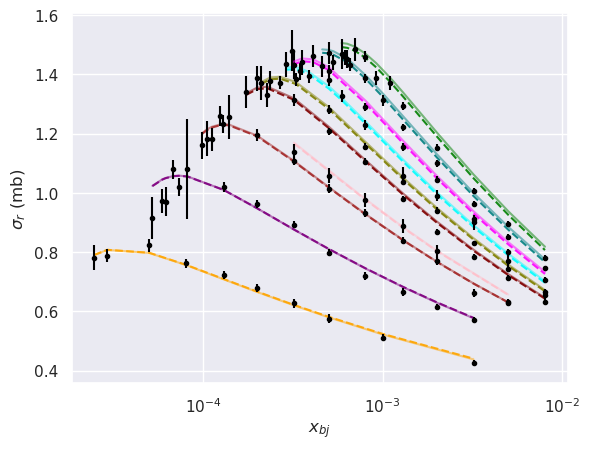

In [31]:
plot_exp_vs_map_vs_median([2., 4.5, 8.5, 10., 15., 18.,  22.,  27.,  35.,  45.], 318.0, MAPT_values, exp_df, median_values)

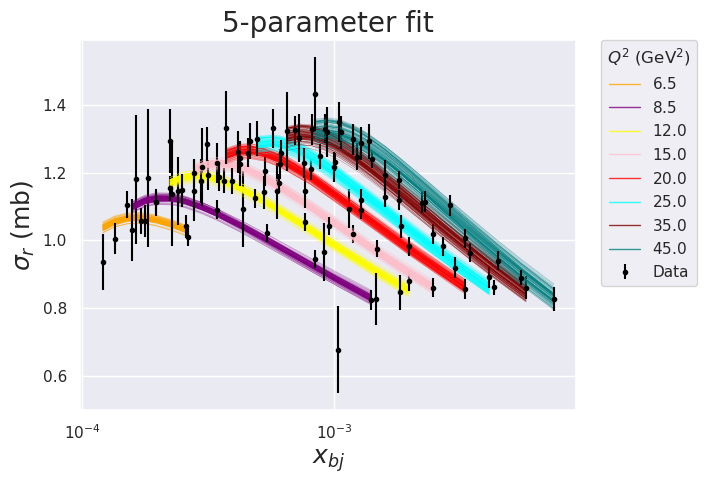

In [32]:
plot_model_vs_exp([6.5, 8.5, 12.0, 15.0, 20.0, 25.0, 35.0, 45.0], 251.0, model_values, exp_df)

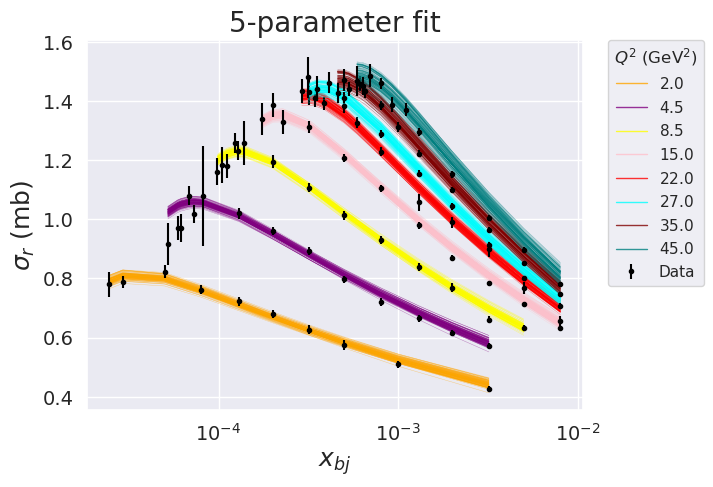

In [33]:
plot_model_vs_exp([2., 4.5, 8.5, 15.0, 22.0,  27.,  35.,  45.], 318.0, model_values, exp_df)

In [34]:
exp_df[['Qs2', 'sqrt(s)']].value_counts().to_frame()

,,0
Qs2,sqrt(s),
12.0,251.0,15
8.5,318.0,14
45.0,251.0,14
6.5,318.0,14
35.0,251.0,14
3.5,318.0,14
4.5,318.0,14
15.0,251.0,14
2.7,318.0,13


In [35]:
def my_chi2(data, obs, obs_err):
    return np.sum(((data - obs)**2)/obs_err**2)/403


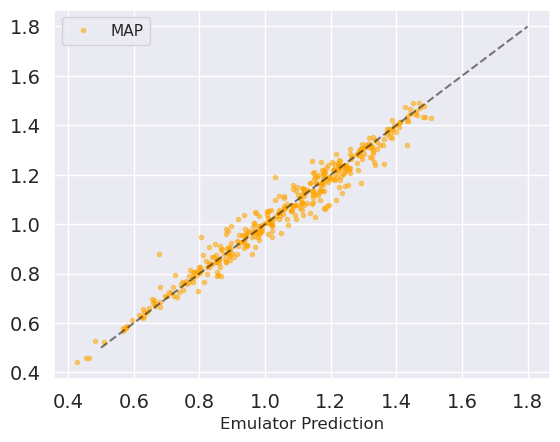

In [36]:
diag = np.linspace(0.5, 1.8)
#plt.plot(exp, median_values.reshape(403), '.', color = 'blue', alpha = 0.5, label = 'Median');
plt.plot(exp, MAPT_values.reshape(403), '.', color = 'orange', alpha = 0.5, label = 'MAP');
plt.plot(diag, diag, '--', color = 'black', alpha = 0.5)
plt.xlabel("Emulator Prediction")
plt.legend()
#plt.ylabel("Model Prediction")

In [37]:
map_x = my_chi2(MAPT_values, exp, exp_err)
median_x = my_chi2(median_values, exp, exp_err)
#chi2(MAPT_values, exp, exp_err)
print('$$\chi^{2}/dof$$ (MAP):' , map_x)
print('$$\chi^{2}/dof$$ (Median):' , median_x)

$$\chi^{2}/dof$$ (MAP): 1.261872792527857
$$\chi^{2}/dof$$ (Median): 1.565999446177277


In [38]:
thetas = np.vstack(np.loadtxt("results/theta.dat", unpack = True)).T
lps = [log_posterior(i, l_bounds, u_bounds, emulators, exp, exp_err) for i in thetas]
print(np.array(lps).T)

[-29.48857243 452.4054716  452.40726071 452.40905721 452.14296766
  97.33274191 290.99808003 114.51211592  64.41428484]


In [39]:
diag = np.linspace(0.5, 1.8)
MAPT_values_model = np.array(np.loadtxt("results/trains/3.txt"))
int = initial_guess.reshape(1, -1) 
initial_values, initial_values_err = return_predictions(emulators, int, return_std_ = True)
plt.plot(exp, MAPT_values.reshape(403), '.', color = 'orange', alpha = 0.5, label = 'MAP');
plt.plot(exp, MAPT_values_model, '.', color = 'blue', alpha = 0.5, label = 'MAP');
#plt.plot(initial_values.reshape(403), MAPT_values_model, '.', color = 'red', alpha = 0.5, label = 'MAP');
plt.plot(diag, diag, '--', color = 'black', alpha = 0.5)
#plt.errorbar(MAPT_values_model, MAPT_values.reshape(403), yerr = MAPT_values_err, fmt='.')

NameError: name 'initial_guess' is not defined